<a href="https://colab.research.google.com/github/tzoung-yu/TrueVolume/blob/main/TrueVolume_RT_1%E4%B8%8A%E5%B8%82%E4%B8%8A%E6%AB%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

統計起始日:2023/01/07
[*********************100%%**********************]  1 of 1 completed
-
-
-
-
realtime done!
2313 華通 上市 電子零組件業
2023-11-03
 54.1


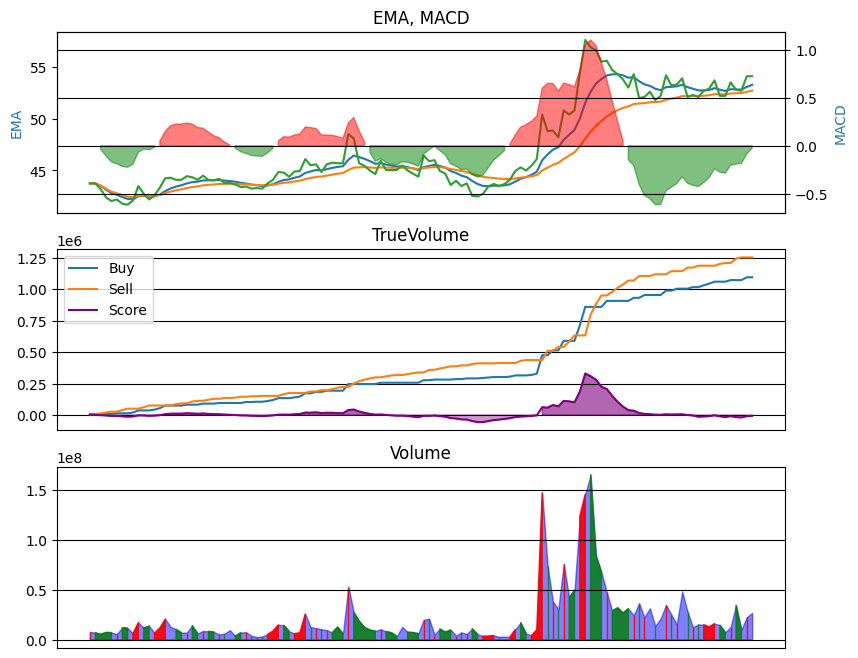

月: True 週: True


In [7]:
!pip install twstock
#!twstock -U
import twstock
from twstock import Stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import matplotlib as mpl
import time
import yfinance as yf

#股票代號
stoid="華通"

thisday = datetime.today()
day_start = thisday - timedelta(days=300)
draw_start = thisday - timedelta(days=180)
#day_start = thisday.replace(month=1, day=1)

def TrueVol(pd):
  df=pd
  global thisday
  global draw_start
  end_date = thisday
  start_date = draw_start
  df = df[df['Date'].between(start_date, end_date)]
  df = df.reset_index(drop=False)
  opp=df['Open']
  clo=df['Close']
  voo=df['Volume']
  hig=df['High']
  llo=df['Low']
  upl=[]
  dol=[]
  bll=[]
  upc=0.0
  dlc=0.0
  blc=0.0
  lp=0.0
  lgv=1.0
  lgc=0.0
  upordown=0.0
  xvo=[]
  for i in range(len(opp)):
    if clo[i]>lgc:
      lgc=clo[i]
    if(lp==0.0):
      lp=opp[i]
    upordown=0
    if(clo[i]>=opp[i]):
      if(clo[i] >= opp[i] + ((hig[i] - opp[i])/3.8) and clo[i]>=lp):
        upc+=(voo[i]/1000)
        upordown=1
      else:
        if clo[i]<lp or (clo[i] < opp[i] + ((hig[i] - opp[i])/5)):
          dlc+=(voo[i]/1000)
          upordown=-1
    else:
      if(clo[i] <= opp[i]-((opp[i]-llo[i])/3.8) and clo[i]<=lp):
        dlc+=(voo[i]/1000)
        upordown=-1
      else:
        if(clo[i] >= llo[i]+((hig[i]-llo[i])/2) and clo[i]>lp):
          upc+=(voo[i]/1000)
          upordown=1
    upl.append(upc)
    dol.append(dlc)
    blc+=voo[i]/1000
    bll.append(blc/2)
    xvo.append(upordown)
    lp=clo[i]
    if(voo[i]/1000 > lgv):
      lgv=voo[i]/1000

  ema10=clo.ewm(span=9).mean()
  ema30=clo.ewm(span=26).mean()

  exp12     = clo.ewm(span=12, adjust=False).mean()
  exp26     = clo.ewm(span=26, adjust=False).mean()
  macd      = exp12 - exp26
  signal    = macd.ewm(span=9, adjust=False).mean()
  histogram = macd - signal

  gg1=max(upl[-1], dol[-1])
  bbb=0.0
  sco=[]
  x=[]
  vlv=9999/lgv
  vlc=999/lgc
  vlm=2/max(abs(histogram))
  for i in range(len(upl)):
    bbb=((ema10.iloc[i]-ema30.iloc[i])*vlc*666)+((upl[i]-dol[i])*vlv)
    histo=abs(bbb)*vlm*histogram[i]
    if (bbb>0 and histo>0) or (bbb<0 and histo<0):
      bbb = bbb+histo
    else:
      bbb = bbb+(histo*0.7)
    sco.append(bbb)
    x.append(str(i))
  sco=np.array(sco)
  gg2=max(abs(sco))
  gg3=gg1/gg2
  sco=sco*gg3/3.8

  gg3=gg1/max(abs(histogram))
  histogram2 = histogram*gg3/10

  mpl.rcParams["figure.figsize"] = (9.4, 8)

  ax1 = plt.subplot(311)
  ax2 = ax1.twinx()
  ax1.set_ylabel('EMA', color='tab:blue')
  ax2.set_ylabel('MACD', color='tab:blue')
  ax1.plot(ema10)
  ax1.plot(ema30)
  ax1.plot(clo)
  ax2.fill_between(x, histogram, where=(histogram<0), color='green', alpha=0.5)
  ax2.fill_between(x, histogram, where=(histogram>0), color='red', alpha=0.5)
  plt.title('EMA, MACD')
  plt.gca().xaxis.set_ticks([])
  plt.grid(color='black')

  plt.subplot(312)
  plt.plot(upl,label='Buy')
  plt.plot(dol,label='Sell')
  plt.gca().xaxis.set_ticks([])
  plt.fill_between(x, sco, where=(sco>0), color='purple', alpha=0.6)
  plt.fill_between(x, sco, where=(sco<0), color='purple', alpha=0.4)
  #plt.fill_between(x, histogram2, where=(histogram2<0), color='green', alpha=0.6)
  #plt.fill_between(x, histogram2, where=(histogram2>0), color='red', alpha=0.6)
  plt.plot(sco, label='Score', color='purple')
  #plt.bar(x, height=sco, color='red','linewidth=0)
  plt.grid(color='black')
  plt.legend()
  plt.title('TrueVolume')

  xvo = np.array(xvo)
  plt.subplot(313)
  plt.title('Volume')
  #plt.plot(voo)
  plt.fill_between(x, voo, where=(voo>0), color='blue', alpha=0.5)
  plt.fill_between(x, voo, where=(xvo<0), color='green', alpha=0.8)
  plt.fill_between(x, voo, where=(xvo>0), color='red', alpha=0.9)
  plt.gca().xaxis.set_ticks([])
  plt.grid(color='black')

  plt.show()

  df1 = pd.set_index('Date')
  # 計算月線EMA
  mEma12 = df1['Close'].resample('M').mean().ewm(span=12).mean()
  mEma26 = df1['Close'].resample('M').mean().ewm(span=26).mean()
  mMacd = mEma12 - mEma26
  mSignal = mMacd.ewm(span=9).mean()
  mHisto = mMacd-mSignal
  # 計算週線EMA
  wEma12 = df1['Close'].resample('W').mean().ewm(span=12).mean()
  wEma26 = df1['Close'].resample('W').mean().ewm(span=26).mean()
  wMacd = wEma12 - wEma26
  wSignal = wMacd.ewm(span=9).mean()
  wHisto = wMacd-wSignal

  MUP=False
  if mHisto.iloc[-1]>0:
    MUP = True
  WUP=False
  if wHisto.iloc[-1]>0:
    WUP = True

  print('月:',MUP,'週:',WUP)

def keep_first_line(text):
    lines = text.splitlines()
    if lines:
        return lines[0]
    else:
        return ""

codes = twstock.codes
df = pd.DataFrame.from_dict(codes, orient='index')

stoname=str(stoid)
if not stoname.isdigit():
  nn = df[df["name"] == stoname]
  stoid=str(nn.code[0])

nn=df[df["code"]==stoid]

# 讀取股價資料
if(nn.market[0]=='上櫃'):
  print("統計起始日:"+draw_start.strftime("%Y/%m"))
  stock = Stock(stoid)
  sto_price = stock.fetch_from(day_start.year, day_start.month)
  sto_attr = ['Date', 'Volume', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction']
  data1 = pd.DataFrame(columns = sto_attr, data = sto_price)
  data1 = data1.drop(['Turnover', 'Change', 'Transaction'], axis=1)

if(nn.market[0]=='上市'):
  print("統計起始日:"+day_start.strftime("%Y/%m/%d"))
  data1 = yf.download(stoid+'.TW',start=day_start, end=thisday)
  data1 = data1.drop(['Adj Close'], axis=1)
  data1 = data1.reset_index(drop=False)

is_working_hour = True
# 判斷現在是否為工作日
if thisday.weekday() not in [0, 1, 2, 3, 4]:
  is_working_hour = False

# 判斷現在時間是否在 9 點到 13 點 25 分
#if thisday.hour < 9 or (thisday.hour >= 13 and thisday.minute >= 30):
  #is_working_hour = False

dfl=data1.tail(1)
tt1=keep_first_line(str(dfl['Date']))
tt1=tt1[-10:]
if tt1==thisday.strftime("%Y-%m-%d"):
  realdone=True

twstock.realtime.mock = False
realdone = False
while(is_working_hour and realdone == False):
  data2 = twstock.realtime.get(stoid)
  if data2['success']:
    rtime=data2['info']['time']
    rtv=data2['realtime']['accumulate_trade_volume']
    ropen=data2['realtime']['open']
    rhigh=data2['realtime']['high']
    rlow=data2['realtime']['low']
    rlp=data2['realtime']['latest_trade_price']
    tt2=rtime[:10]
    if rlp != '-':
      if (tt2 != tt1):
        if(nn.market[0]=='上櫃'):
          data1.loc[len(data1)] = [datetime.strptime(tt2,"%Y-%m-%d"), int(rtv)*1000, float(ropen),float(rhigh),float(rlow),float(rlp)]
        if(nn.market[0]=='上市'):
          data1.loc[len(data1)] = [datetime.strptime(tt2,"%Y-%m-%d"), float(ropen),float(rhigh),float(rlow),float(rlp), int(rtv)*1000]
      print("realtime done!")
      realdone = True
    else:
      print(rlp)
  if realdone==False:
    time.sleep(5)

print(stoid, nn.name[0], nn.market[0],nn.group[0])

df=data1.tail(1)
tt1=str(df["Date"])
tt1= keep_first_line(tt1)
print(tt1[-10:])
tt1=str(round(df["Close"],2))
tt1= keep_first_line(tt1)
print(tt1[6:])

TrueVol(data1)